In [2]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from absl import app, flags
from tqdm import tqdm

In [3]:
#!pip install wandb --upgrade

In [4]:
# import wandb
# wandb.login()

# run = wandb.init(
#     project="nam-original",
#     notes="My first experiment",
#     tags=["baseline"],
# )

In [5]:
# Ensure deterministic behavior
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset

In [6]:
def get_data(num_exp=10, in_features=5):
    # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
    X_uniform = Uniform(-1, 1).sample((num_exp, in_features-2))
    
    # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
    X_normal = torch.normal(0, 1, (num_exp, 2))
    
    # Combine the uniform and normal features
    X = torch.cat([X_uniform, X_normal], dim=1)
    print(X.shape)
    
    # creating y_1
    y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * torch.log(100 * X[:, 5].abs()) + torch.sin(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    print(y_2.shape)
    
    # Stack y_1 and y_2 to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return X, y



def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [7]:
X, y = get_data(num_exp=1, in_features=7)
y

torch.Size([1, 7])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 2])


tensor([[0.5342, 0.0975]])

In [8]:
# seed_everything(42)
    
# # Generating synthetic data using a normal distribution
# x1 = torch.normal(0, 1, (1000,))
# x2 = torch.normal(0, 1, (1000,))
# x3 = torch.normal(0, 1, (1000,))
# y = 4 * x1 + x2**2 + x3**3

# x_data = torch.stack([x1, x2, x3], dim=1)
# y_data = y + torch.randn_like(y) * 0.1  # Adding some noise

# Model architecture

In [9]:
def truncated_normal_(tensor, mean: float = 0., std: float = 1.):
    """
    Initializes a tensor with values from a truncated normal distribution
    """
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

# ActivationLayer Class
class ActivationLayer(torch.nn.Module):
    """
    Abstract base class for layers with weights and biases
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__()
        
        self.weight = torch.nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.empty(in_features))

    def forward(self, x):
        raise NotImplementedError("abstract method called")


class ExULayer(ActivationLayer):
    """
    Custom layer using exponential activation with weight and bias initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        truncated_normal_(self.weight, mean=4.0, std=0.5)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x): 
        exu = (x - self.bias) @ torch.exp(self.weight)
        output = torch.clip(exu, 0, 1)
        
        if 0:
            print('ExULayer_weights:', self.weight.detach().cpu().numpy())
            print('ExULayer Normalization L1\n:', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ExULayer Normalization L2\n:',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


class ReLULayer(ActivationLayer):
    """
    Custom layer using ReLU activation with Xavier weight initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        torch.nn.init.xavier_uniform_(self.weight)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x):
        output = F.relu((x - self.bias) @ self.weight)
        
        if 0:
            print('ReLULayer_weights:', self.weight.detach().cpu().numpy())
            print('ReLULayer Normalization L1:\n', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ReLULayer Normalization L2:\n',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


# FeatureNN Class
class FeatureNN(torch.nn.Module):
    """
    Neural network for individual features
    """
    def __init__(self,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 dropout: float = .5,
                 latent_var_dim: int = 1,
                 ):
        super().__init__()
        
        # First (shallow) layer
        self.shallow_layer = shallow_layer(1, shallow_units)
        
        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        in_units = shallow_units
        for out_units in hidden_units:
            self.hidden_layers.append(hidden_layer(in_units, out_units))
            in_units = out_units  # Update in_units to the output of the last layer
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Output linear layer
        self.output_layer = torch.nn.Linear(in_units, latent_var_dim, bias=False)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Pass through the shallow layer
        x = self.shallow_layer(x)
        #x = self.dropout(x)
        
        # Pass through each hidden layer with dropout
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.dropout(x)
            
        # Final output layer
        x = self.output_layer(x)
        
        return x


# Neural Additive Model (NAM) Class
class NeuralAdditiveModel(torch.nn.Module):
    """
    Combines multiple feature networks, each processing one feature, with dropout and bias
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 feature_dropout: float = 0.,
                 hidden_dropout: float = 0.,
                 latent_var_dim: int = 1,
                 ):
        super().__init__()
        
        self.input_size = input_size

        if isinstance(shallow_units, list):
            assert len(shallow_units) == input_size
        elif isinstance(shallow_units, int):
            shallow_units = [shallow_units for _ in range(input_size)]

        self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units[i],
                      hidden_units=hidden_units,
                      shallow_layer=shallow_layer,
                      hidden_layer=hidden_layer,
                      dropout=hidden_dropout,
                      latent_var_dim=latent_var_dim)
            for i in range(input_size)
        ])
        self.feature_dropout = torch.nn.Dropout(p=feature_dropout)
        self.bias = torch.nn.Parameter(torch.zeros(latent_var_dim))

    def forward(self, x):
        # Collect outputs from each feature network
        FeatureNN_out = self._feature_nns(x)
        
        # Concatenates a sequence of tensors along the latent features dimension 
        f_out = torch.stack(FeatureNN_out, dim=-1)
        
        # Sum across features and add bias
        f_out = self.feature_dropout(f_out)
        outputs = f_out.sum(axis=-1) + self.bias
        
#         # Apply softmax to get class probabilities
#         output = torch.softmax(output, dim=-1)
        
        if 0:
            print('final output', outputs)
            print('f_out', f_out)
        return outputs, f_out

    def _feature_nns(self, x):
        return [self.feature_nns[i](x[:, i]) for i in range(self.input_size)]

In [10]:
# a basic numerical example that demonstrates the functionality of the key parts of the NeuralAdditiveModel class

if 0:
    import torch
    import torch.nn as nn

    # Simplified FeatureNN that outputs 3 values per feature (for 3 classes)
    class SimpleFeatureNN(nn.Module):
        def __init__(self, num_features, num_classes):
            super().__init__()
            self.input_layer = torch.nn.Linear(1, num_features)
            self.output_layer = torch.nn.Linear(num_features, num_classes)

        def forward(self, x):
            # Linear transformation: output = weight * x + bias
            x = self.input_layer(x)
            x = self.output_layer(x)
            return x

    # Simplified NeuralAdditiveModel
    class SimpleNeuralAdditiveModel(nn.Module):
        def __init__(self, num_features=5, num_classes=3):
            super().__init__()
            self.input_size = num_features
            self.feature_nns = nn.ModuleList([SimpleFeatureNN(num_features, num_classes) for _ in range(num_features)])
            self.bias = nn.Parameter(torch.tensor([0.5, 0.6, 0.7]))  # Bias for each class

        def forward(self, x):
            input_fe = self._feature_nns(x)
            print('-----------------')
            print(input_fe)
            # Collect outputs from each feature network
            f_out = torch.stack(input_fe, dim=-1)  # Shape: [batch_size, num_classes, num_features]
            print('-----------------')
            print(f_out)
            # Sum across features
            f_out_sum = f_out.sum(dim=-1)  # Shape: [batch_size, num_classes]
            print('-----------------')
            print(f_out_sum)
            # Add bias
            output = f_out_sum + self.bias
            print('-----------------')
            print(output)
            # Apply softmax to get class probabilities
            output = torch.softmax(output, dim=-1)
            print('-----------------')
            print(output)

            return output, f_out

        def _feature_nns(self, x):
            return [self.feature_nns[i](x[:, i].unsqueeze(-1)) for i in range(self.input_size)]

    # Step 3: Test the Model with a Simple Input

    # Define a simple input tensor with 2 features for 1 sample (batch_size = 1)
    x_input = torch.tensor([[1.0, 2.0, 1.5, 2.5, 3.0]])  # Shape: [1, 2] (1 sample, 2 features)
    print(x_input)
    # Initialize the simple model
    model = SimpleNeuralAdditiveModel(num_features=5, num_classes=3)

    # Perform a forward pass
    output, f_out = model(x_input)

# Loss

In [11]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Model training

In [12]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
    total_batches = len(loader) * config['epochs']
    example_ct = 0  # number of examples seen
    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0001)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss

# Define the Experiment

In [51]:
# define experiment
config = dict(
    epochs=2000, #100
    batch_size=1024, #128
    learning_rate=0.003,
    num_exp = 5000,
    in_features = 7,
    shallow_units=20, #50
    hidden_units=(64, 64, 32), #(100, 20)
    feature_dropout=0.2,
    hidden_dropout=0.2,
    latent_dim=2,
    seed=42,
    dataset="Uniform_distribution",
    architecture="multi_output_NAM")

In [52]:
config['shallow_units']

20

In [53]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_data(num_exp=config['num_exp'], in_features=config['in_features'])
    train_loader = make_loader(X, y, batch_size=config['batch_size'])

    # Make the model
    model = NeuralAdditiveModel(input_size= config['in_features'],
                     shallow_units= config['shallow_units'],
                     hidden_units= config['hidden_units'],
                     shallow_layer = ExULayer,
                     hidden_layer = ReLULayer,
                     feature_dropout = config['feature_dropout'],
                     hidden_dropout = config['hidden_dropout'],
                     latent_var_dim = config['latent_dim'],           
                     ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=0.0001
                                )
    
    return model, train_loader, criterion, optimizer

# Run

In [54]:
# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)
model

torch.Size([5000, 7])
torch.Size([5000, 1])
torch.Size([5000, 1])
torch.Size([5000, 2])


<ipython-input-6-ebfcbe85936a>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


NeuralAdditiveModel(
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (shallow_layer): ExULayer()
      (hidden_layers): ModuleList(
        (0): ReLULayer()
        (1): ReLULayer()
        (2): ReLULayer()
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (output_layer): Linear(in_features=32, out_features=2, bias=False)
    )
    (1): FeatureNN(
      (shallow_layer): ExULayer()
      (hidden_layers): ModuleList(
        (0): ReLULayer()
        (1): ReLULayer()
        (2): ReLULayer()
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (output_layer): Linear(in_features=32, out_features=2, bias=False)
    )
    (2): FeatureNN(
      (shallow_layer): ExULayer()
      (hidden_layers): ModuleList(
        (0): ReLULayer()
        (1): ReLULayer()
        (2): ReLULayer()
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (output_layer): Linear(in_features=32, out_features=2, bias=False)
    )
    (3): FeatureNN(
      (shallow_layer): ExULayer()
  

  0%|                                                                                 | 1/2000 [00:00<06:38,  5.01it/s]

Epoch 0 | Total Loss: 9.03259


  5%|████                                                                           | 102/2000 [00:18<05:25,  5.84it/s]

Epoch 100 | Total Loss: 0.52264


 10%|███████▉                                                                       | 202/2000 [00:35<05:18,  5.65it/s]

Epoch 200 | Total Loss: 0.47927


 15%|███████████▉                                                                   | 302/2000 [00:53<04:46,  5.92it/s]

Epoch 300 | Total Loss: 0.41625


 20%|███████████████▊                                                               | 401/2000 [01:12<05:34,  4.78it/s]

Epoch 400 | Total Loss: 0.41364


 25%|███████████████████▊                                                           | 501/2000 [01:35<05:25,  4.60it/s]

Epoch 500 | Total Loss: 0.33391


 30%|███████████████████████▋                                                       | 601/2000 [02:00<05:46,  4.03it/s]

Epoch 600 | Total Loss: 0.32729


 35%|███████████████████████████▋                                                   | 701/2000 [02:25<06:09,  3.52it/s]

Epoch 700 | Total Loss: 0.28466


 40%|███████████████████████████████▋                                               | 801/2000 [02:55<06:16,  3.18it/s]

Epoch 800 | Total Loss: 0.27698


 45%|███████████████████████████████████▌                                           | 901/2000 [03:27<05:52,  3.12it/s]

Epoch 900 | Total Loss: 0.27620


 50%|███████████████████████████████████████                                       | 1001/2000 [04:00<05:35,  2.98it/s]

Epoch 1000 | Total Loss: 0.27026


 55%|██████████████████████████████████████████▉                                   | 1101/2000 [04:34<05:03,  2.96it/s]

Epoch 1100 | Total Loss: 0.27080


 60%|██████████████████████████████████████████████▊                               | 1201/2000 [05:09<04:23,  3.04it/s]

Epoch 1200 | Total Loss: 0.26813


 65%|██████████████████████████████████████████████████▋                           | 1301/2000 [05:43<04:28,  2.60it/s]

Epoch 1300 | Total Loss: 0.27095


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [06:18<03:18,  3.02it/s]

Epoch 1400 | Total Loss: 0.26583


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [06:54<02:50,  2.93it/s]

Epoch 1500 | Total Loss: 0.26968


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [07:29<02:31,  2.63it/s]

Epoch 1600 | Total Loss: 0.26949


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [08:06<01:52,  2.66it/s]

Epoch 1700 | Total Loss: 0.26427


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [08:45<01:13,  2.70it/s]

Epoch 1800 | Total Loss: 0.26565


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [09:22<00:38,  2.60it/s]

Epoch 1900 | Total Loss: 0.26653


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:58<00:00,  3.34it/s]


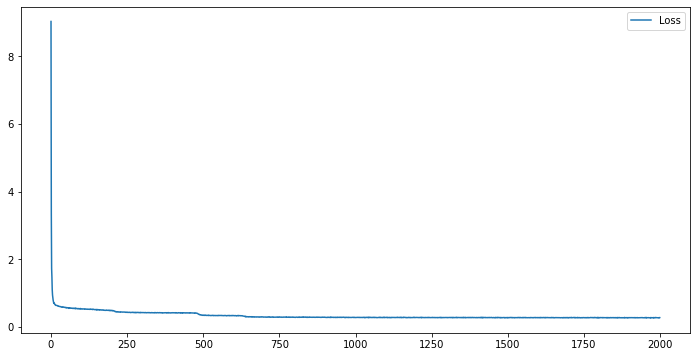

In [55]:
# and use them to train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

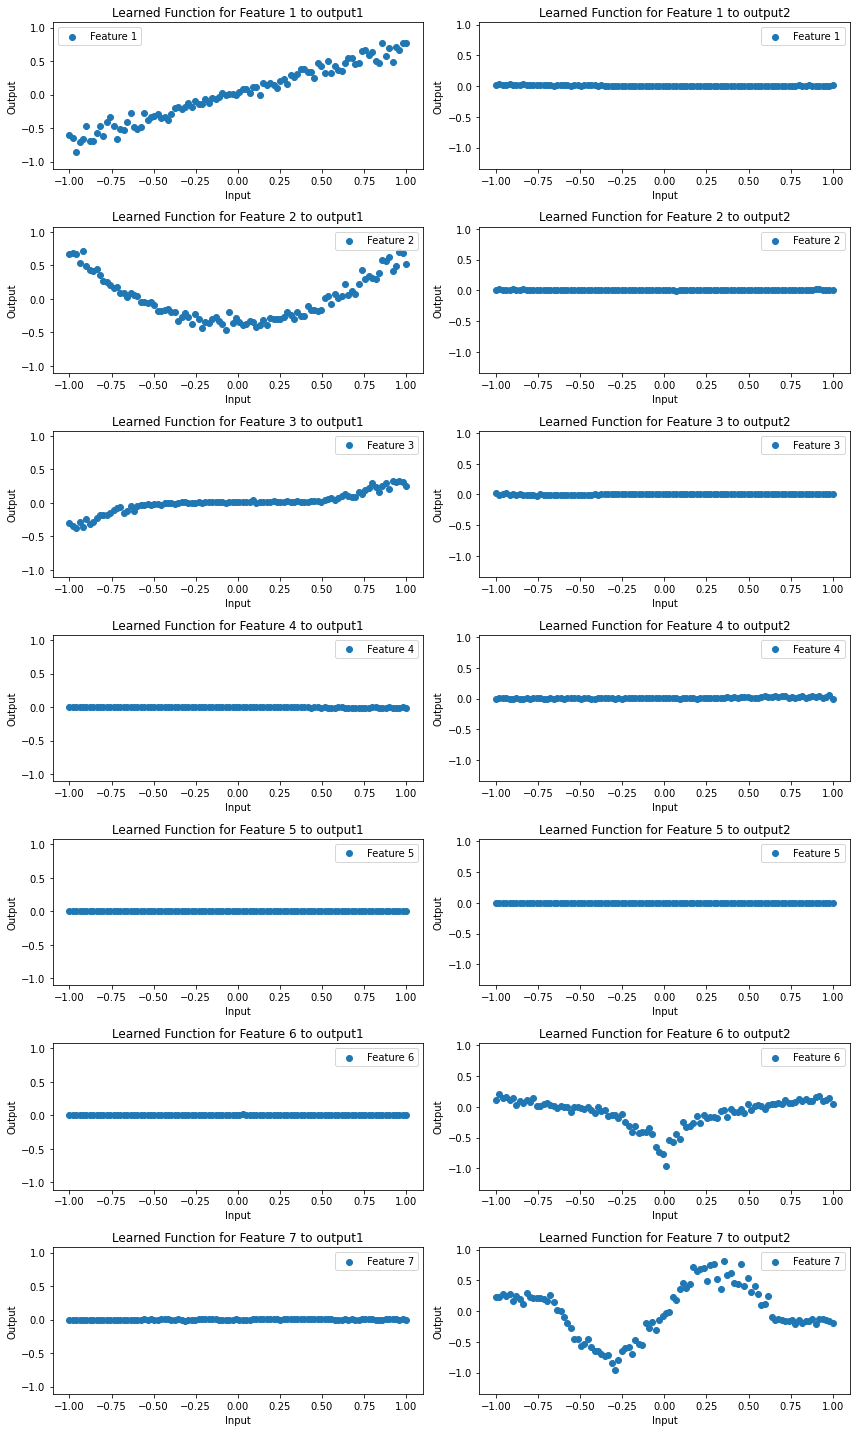

In [56]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

# Plot learned functions
fig, axes = plt.subplots(config['in_features'],2, figsize=(12,20))

feature_output1_max = [] 
feature_output1_min = [] 

feature_output2_max = [] 
feature_output2_min = [] 

for i in range(config['in_features']):
    with torch.no_grad():
        feature_input = x_values
        feature_output_1 = model.feature_nns[i](feature_input[:, 0])[:, 0].cpu().numpy()
        feature_output_2 = model.feature_nns[i](feature_input[:, 0])[:, 1].cpu().numpy()
    
    feature_output1_max.append(max(feature_output_1)) 
    feature_output1_min.append(min(feature_output_1))
    
    feature_output2_max.append(max(feature_output_2)) 
    feature_output2_min.append(min(feature_output_2))

    
for i in range(config['in_features']):
    with torch.no_grad():
        # Plot 1
        ax1 = axes[i, 0]
        ax1.scatter(x_values.cpu().numpy(), model.feature_nns[i](feature_input[:, 0])[:, 0].cpu().numpy(), label=f'Feature {i+1}')
        ax1.set_title(f'Learned Function for Feature {i+1} to output1')
        ax1.set_xlabel('Input')
        ax1.set_ylabel('Output')
        ax1.set_ylim([min(feature_output1_min)*1.3, max(feature_output1_max)*1.3])
        ax1.legend()
        
        # Plot 1
        ax2 = axes[i, 1]
        ax2.scatter(x_values.cpu().numpy(), model.feature_nns[i](feature_input[:, 0])[:, 1].cpu().numpy(), label=f'Feature {i+1}')
        ax2.set_title(f'Learned Function for Feature {i+1} to output2')
        ax2.set_xlabel('Input')
        ax2.set_ylabel('Output')
        ax2.set_ylim([min(feature_output2_min)*1.3, max(feature_output2_max)*1.3])
        ax2.legend()

plt.tight_layout()
plt.show()

# Old

In [80]:
input_size = x_data.shape[-1]
shallow_units = 500
hidden_units = (300, 100)

model = NeuralAdditiveModel(input_size=input_size,
                 shallow_units=shallow_units,
                 hidden_units=hidden_units,
                 shallow_layer = ExULayer,
                 hidden_layer = ReLULayer,
                 feature_dropout = 0.0,
                 hidden_dropout = 0.0,
                 )

lr=0.4
optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=lr,
                                  weight_decay=0.0
                             )
#criterion = torch.nn.MSELoss()
criterion = penalized_mse
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=100, epochs=1000)
#StepLR(optimizer, gamma=1, step_size=1)

train_dataset = TensorDataset(torch.tensor(x_data), torch.tensor(y_data))
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

<ipython-input-80-fcd7a1a4c170>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(x_data), torch.tensor(y_data))


train (100/5000) | loss = 31.83157: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]
train (200/5000) | loss = 31.80177: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]
train (300/5000) | loss = 31.78449: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]
train (400/5000) | loss = 31.77496: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]
train (500/5000) | loss = 31.76996: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]
train (600/5000) | loss = 31.76748: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]
train (700/5000) | loss = 31.76634: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]
train (800/5000) | loss = 31.76584: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.98it/s]
train (900/5000) | loss = 31.76563: 100%

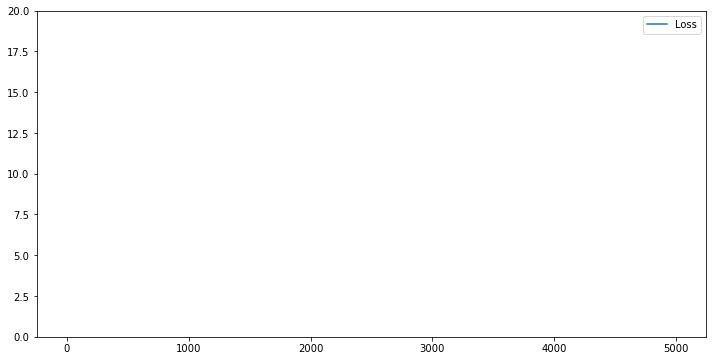

In [89]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, n_epochs, verbose=False):
    pbar = tqdm.tqdm(enumerate(data_loader, start=1), total=len(data_loader), disable=not verbose)
    total_loss = 0
    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)
        logits, fnns_out = model.forward(x)
        loss = criterion(logits, y, fnns_out, feature_penalty=0.0)
        #print(loss.item)
        total_loss += loss.item()
        #print(total_loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"train ({epoch+1}/{n_epochs}) | loss = {total_loss:.5f}")
        
    avg_loss = total_loss / len(data_loader)
    wandb.log({"loss": avg_loss})
    return avg_loss

history = []
n_epochs = 5000 #2000 #1000

for epoch in range(n_epochs):
    model = model.train()
    verbose = (epoch + 1) % 100 == 0
    total_loss = train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, n_epochs, verbose=verbose)
    
    history.append(total_loss)
#     if verbose:
#         print(f"Epoch {epoch + 1} | Total Loss: {total_loss:.5f}")  
        
    scheduler.step()

plt.figure(figsize=(12, 6))
plt.plot(np.array(history))
plt.legend(['Loss'])
plt.ylim([0,20])
plt.show()

In [ ]:
def train_model(x_train, y_train, x_validate, y_validate, device):
    model = NeuralAdditiveModel(
        input_size=x_train.shape[-1],
        shallow_units=nam.data_utils.calculate_n_units(x_train, FLAGS.n_basis_functions, FLAGS.units_multiplier),
        hidden_units=list(map(int, FLAGS.hidden_units)),
        shallow_layer=ExULayer if FLAGS.shallow_layer == "exu" else ReLULayer,
        hidden_layer=ExULayer if FLAGS.hidden_layer == "exu" else ReLULayer,
        hidden_dropout=FLAGS.dropout,
        feature_dropout=FLAGS.feature_dropout).to(device)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=0.01,
                                  weight_decay=0.01)
    criterion = nam.metrics.penalized_mse if FLAGS.regression else nam.metrics.penalized_cross_entropy
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)

#     train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
#     train_loader = DataLoader(train_dataset, batch_size=FLAGS.batch_size, shuffle=True)
#     validate_dataset = TensorDataset(torch.tensor(x_validate), torch.tensor(y_validate))
#     validate_loader = DataLoader(validate_dataset, batch_size=FLAGS.batch_size, shuffle=True)

#    n_tries = FLAGS.early_stopping_epochs
#    best_validation_score, best_weights = 0, None

    for epoch in range(5000):
        model = model.train()
        total_loss = train_one_epoch(model, criterion, optimizer, train_loader, device)
        logging.info(f"epoch {epoch} | train | {total_loss=}")

        scheduler.step()

#         model = model.eval()
#         metric, val_score = evaluate(model, validate_loader, device)
#         logging.info(f"epoch {epoch} | validate | {metric}={val_score}")

#         # early stopping
#         if val_score <= best_validation_score and n_tries > 0:
#             n_tries -= 1
#             continue
#         elif val_score <= best_validation_score:
#             logging.info(f"early stopping at epoch {epoch}")
#             break
#         best_validation_score = val_score
#         best_weights = copy.deepcopy(model.state_dict())

#     model.load_state_dict(best_weights)

    return model


def train_one_epoch(model, criterion, optimizer, data_loader, device):
    pbar = tqdm.tqdm(enumerate(data_loader, start=1), total=len(data_loader))
    total_loss = 0
    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)
        logits, fnns_out = model.forward(x)
        loss = criterion(logits, y, fnns_out, feature_penalty=FLAGS.output_regularization)
        total_loss -= (total_loss / i) - (loss.item() / i)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"train | loss = {total_loss:.5f}")
    return total_loss